# Tutorial for reflectance calculations with polarization in the structural-color package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Introduction to how polarization is implemented in the package

Polarization plays a role in several calculations throughout the structural-color package:

1. Cross sections
<br>
In the single scattering model used in this package, the cross sections are proportional to the structure factor * form factor, where the form factor comes from Mie theory. Mie theory solves Maxwell's equations for spheres, giving the scattered electric fields, which we use to calculate scattered intensity and scattering cross sections. The Mie solutions are polarization-dependent; we use Mie theory to find Jones or Stokes vectors to describe the fields, whose components reveal the polarization state. 
<br>
<br>
Most Mie solutions are performed in a basis defined by the scattering plane. So the Jones vector describes the scattered electric field components in terms of the scattered light that has polarization parallel to the scattering plane and the scattered light that is perpendicular to the scattering plane. (Remember, the scattering plane is the plane that contains the incident and scattered k-vectors of the light). Here's the way the Jones vector is written in this basis:
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{||} \\ E_{\perp}\end{bmatrix}$
<br>
<br>
This scattering plane basis is not ideal if you want to actually compare to any measured polarizations, because in the lab, we do not measure polarization according to its relation to the scattering plane, we measure it in the lab frame, which is not related to the scattering vectors of the light at all. And more specifically, we like to measure things in cartesian coordinates because it's intuitive. So we rotate the scattering matrix that comes from the Mie calculations, which allows us to get an expression for the Jones vector in a cartesian basis. 
<br>
<br>
$E_{scat} = \begin{bmatrix}E_{x} \\ E_{y}\end{bmatrix}$
<br>
<br>
Now looking at this expression, you'll notice that there is no z component. The absence of z happens because we are assuming that the light is traveling in the +z direction, and under circumstances relevant to the model, polarization cannot be parallel to the direction of propagation. At this point, we can calculate the scattering cross sections in this cartesian coordinate system be doing a bit of math. To read more about this, see the docstrings of functions in mie.py. I worked very hard on them, and there is no point in repeating them here. 
<br>
<br>
2. Polarization vector
<br>
The polarization vector tells us the polarization direction of the the light, or in the case of the Monte Carlo model, the photon packets. It's often expressed as a Stokes or Jones vector, and it can be calculated by normalizing the above $E_{scat}$.  
<br>
But it's not quite that simple. We have to be careful here. This Jones vector is in a cartesian coordinate system that is no longer dependent on the incident and scattered vectors as the scattering plane basis is. But this cartesian coordinate system is not the one we care about for comparing to measurements. Why? Because these coordinates are are defined in the local coordinate system of the light, or a photon packet, in the language of the Monte Carlo model. No matter the global direction of the light, it always sees itself as traveling in it's own +z direction. If it changes direction, as it will in the Monte Carlo model, it rotates it's coordinate system, so that it always is traveling in it's own +z direction. 
<br>
<br>
We experimentalists do not care what direction the photon packet thinks it is traveling in; we care about the direction relative to our own world: the global lab frame. So we do another rotation, one that brings the expression for the field into a global cartesian coordinate system that assumes the normal to a film sample is in the -z direction, meaning normally incident light travels in the +z direction. The +x, and +y directions can be found according to right hand rule. So our new expression for the E-field has 3 components:
<br>
<br>
$ E_{scat} = \begin{bmatrix}E_{x} \\ E_{y}\\ E_{z}\end{bmatrix}$
<br>
<br>
This is the format of the polarization vectors that are attributes of a Trajectory object. 
<br>
<br>
3. Phase function
<br>
The final place the polarization comes in is in the phase function. The phase function is the probability distribution of scattering angles, and it's calculated by just normalizing the differential cross section:
<br>
<br>
$p(\theta, \phi) = \frac{\frac{d\sigma(\theta, \phi)}{d\Omega}}{\sigma}$
<br>
<br>
You'll notice that it's a function of $\theta$ and $\phi$. For unpolarized light, we don't have to worry about the $\phi$ dependence in our samples because both the structure factors and the form factors for unpolarized light are constant as a function of $\phi$. Polarized light is a different story. For polarized incident light, we do have to calculate the phase function as a function of $\theta$ and $\phi$.
<br>
<br>
Having a phase function that depends on two variables means that our phase function is now a 2-dimentional array instead of a 1-dimensional array, and the sampling of the angles is a bit more complicated and time-consuming. This is all under the hood though--you (the user) won't have to fuss with the different possible dimensions of the phase function, but I think it's good to know in case you ever want to plot the phase function.  

**FAQ


Q: If polarization is always calculated in Mie theory, what do we do with it in the calculations where we assume the light is unpolarized? 
<br>
A: We average the parallel and perpendicular components. This is derived on pg 73 of Bohren and Huffman's $\textit{Absorption and Scattering of Light by Small Particles}$


Q: Is polarization implemented in both the single scattering model and the Monte Carlo model?
<br>
A: Currently, polarization is only fully implemented in the Monte Carlo model. However, it is certainly possible to add it to the single scattering model in the future


### Loading and using the package

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
from structcol import refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
import pymie as pm
from pymie import size_parameter, index_ratio 
import seaborn as sns
import time

# For Jupyter notebooks only:
%matplotlib inline

### Run Monte Carlo model and calculate reflectance and polarization for trajectories
#### for a single wavelength

set system parameters

In [15]:
# incident light wavelength
wavelength = sc.Quantity('600 nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-4
n_particle = ri.n('polystyrene', wavelength) + n_imag    # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample
n_sample = ri.n_eff(n_particle,         # refractive index of sample, calculated using Bruggeman approximation
                    n_matrix, 
                    volume_fraction)
thickness = sc.Quantity('80 um')
boundary = 'film'

# Monte Carlo parameters
ntrajectories = 300                   # number of trajectories
nevents = 300                         # number of scattering events in each trajectory

initialize and run trajectories

In [16]:
# Calculate scattering quantities
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, 
                                  volume_fraction, wavelength, polarization= True)

# Initialize trajectories
r0, k0, W0, p0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, boundary, polarization=True)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')
p0 = sc.Quantity(p0,'')

trajectories = mc.Trajectory(r0, k0, W0, p0)

# Sample trajectory angles
sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents, 
                                                           ntrajectories,p)
# Sample step sizes
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

# Update trajectories based on sampled values
trajectories.scatter(sintheta, costheta, sinphi, cosphi)
trajectories.polarize(theta, phi, sintheta, costheta, sinphi,cosphi,
                      n_particle, n_sample, radius, wavelength, volume_fraction)
trajectories.move(step)
trajectories.absorb(mu_abs, step)  

calculate reflectance

In [17]:
reflectance, transmittance = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary)

print('Reflectance: ' + str(reflectance))
print('Transmittance: ' + str(transmittance))

Reflectance: 0.920721675554
Transmittance: 0.0792783244455


### Run Monte Carlo model and calculate reflectance and polarization for trajectories
#### for the full visible spectrum

set system parameters

In [18]:
# incident light wavelength
wavelengths = sc.Quantity(np.arange(400, 800, 20), 'nm')

# sample parameters
radius = sc.Quantity('0.140 um')
volume_fraction = sc.Quantity(0.55, '')
n_imag = 2.1e-4
n_particle = ri.n('polystyrene', wavelengths) + n_imag   # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample

thickness = sc.Quantity('80 um')
z_low = sc.Quantity('0 um')

# Monte Carlo parameters
ntrajectories = 300                   # number of trajectories
nevents = 300                         # number of scattering events in each trajectory

initialize trajectories, run trajectories, and calculate reflectance for each wavelength

In [19]:
reflectance = np.zeros(wavelengths.size)
pol_refl_x = np.zeros(wavelengths.size)
pol_refl_y = np.zeros(wavelengths.size)
pol_refl_z = np.zeros(wavelengths.size)

for i in range(wavelengths.size):
    
    # calculate n_sample
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)
    
    # Calculate scattering quantities
    p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle[i], n_sample, 
                                      volume_fraction, wavelengths[i], polarization= True)

    # Initialize trajectories
    r0, k0, W0, p0 = mc.initialize(nevents, ntrajectories, n_medium[i], n_sample, boundary, polarization=True)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    p0 = sc.Quantity(p0,'')

    trajectories = mc.Trajectory(r0, k0, W0, p0)

    # Sample trajectory angles
    sintheta, costheta, sinphi, cosphi, theta, phi= mc.sample_angles(nevents, 
                                                               ntrajectories,p)
    # Sample step sizes
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

    # Update trajectories based on sampled values
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)
    trajectories.polarize(theta, phi, sintheta, costheta, sinphi,cosphi,
                          n_particle[i], n_sample, radius, wavelengths[i], volume_fraction)
    trajectories.move(step)
    trajectories.absorb(mu_abs, step)  
    
    # calculate reflectance and other values of interest
    refl_indices, trans_indices, _, _, _, _, _, _, _, _, _, reflectance[i], _ = det.calc_refl_trans(trajectories, 
                                                                                thickness, n_medium[i], n_sample,
                                                                                boundary, return_extra = True)
    
    # calculate reflectance contribution from each polarization component
    pol_refl_x[i], pol_refl_y[i], pol_refl_z[i] = det.calc_pol_frac(trajectories, refl_indices)

Plot reflectance and polarization spectra

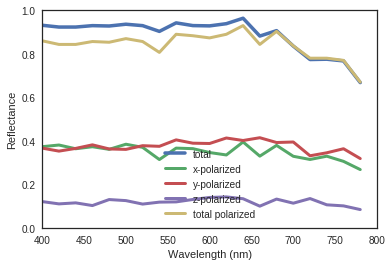

In [20]:
sns.set_style('white')
plt.figure()
plt.plot(wavelengths, reflectance , label = 'total', linewidth = 3.5)
plt.plot(wavelengths, pol_refl_x, label = 'x-polarized', linewidth = 3)
plt.plot(wavelengths, pol_refl_y, label = 'y-polarized', linewidth = 3)
plt.plot(wavelengths, pol_refl_z, label = 'z-polarized', linewidth = 3)
plt.plot(wavelengths, pol_refl_x + pol_refl_y + pol_refl_z, label = 'total polarized', linewidth = 3)
plt.xlim([400,800])
plt.ylim([0,1])
plt.ylabel('Reflectance')
plt.xlabel('Wavelength (nm)')
plt.legend()

This plot shows the contribution to reflectance from light which each of three possible polarization vectors in the global lab coordinate system. The total reflectance nearly overlaps with the sum of the three polarization compontents. The lack of a perfect overlap is due to any extra reflectance which is calculated outside of the trajectories themselves. This includes fresnel reflections at the initial medium-sample interface and the distribution of trajectories that were stuck inside the sample at the end of the Monte Carlo calculation. 